# ０～９までの数字の画像からどの数字なのかを推論する畳み込みニューラルネットワーク（CNN）モデルの構築

#### データセットの準備

In [17]:
!pip install datasets
!pip install japanize-matplotlib
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [1]:
from datasets import load_dataset
ds = load_dataset("ylecun/mnist")

c:\Users\uenoj\MyPython\deep-learning\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np

#### データセットの確認

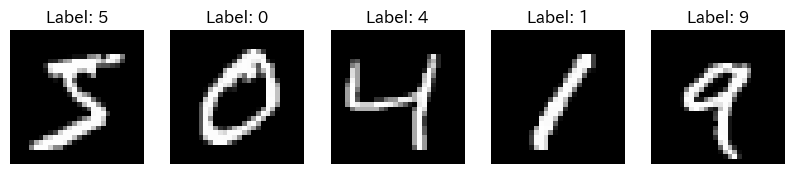

In [4]:
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i, ax in enumerate(axes):
    image = ds['train'][i]['image']
    ax.imshow(image, cmap='gray')
    ax.set_title(f"Label: {ds['train'][i]['label']}")
    ax.axis('off')
plt.show()

In [5]:
ds['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 5}

In [6]:
print(f"画像サイズ {image.size}")

画像サイズ (28, 28)


In [3]:
# 型の変換
ds.set_format(type='torch', columns=['image', 'label'])

#### 畳み込みニューラルネットワークのモデルを定義

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPUを使用します")
else:
    device = torch.device("cpu")
    print("CPUを使用します")
print(device)

GPUを使用します
cuda


In [17]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        # x = x.view(-1, 64)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x

model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


##### モデルの動作確認

In [10]:
# 1つ目のデータを取得
train_loader = torch.utils.data.DataLoader(ds['train'])
data_iter = iter(train_loader)
batch = next(data_iter)
images, labels = batch['image'], batch['label']
print(images.size())
print(labels)

torch.Size([1, 1, 28, 28])
tensor([5])


In [11]:
# 1つ目のデータをモデルに入力
pred = model(images.squeeze(2).float().to(device))
print(f"output shape: {pred.shape}")
print(pred.min(), pred.max())
print(pred)

output shape: torch.Size([1, 10])
tensor(0.0003, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4388, device='cuda:0', grad_fn=<MaxBackward1>)
tensor([[4.2347e-01, 5.3453e-03, 7.1706e-03, 9.9545e-03, 5.7190e-03, 1.2422e-03,
         1.0371e-01, 4.3877e-01, 3.4537e-04, 4.2792e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


#### 損失関数とオプティマイザーを設定

In [22]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

#### モデルを訓練

In [23]:
targets = ds['train']['label'].numpy()
class_counts = np.bincount(targets)
class_weights = 1 / class_counts
sample_weights = class_weights[targets]

sampler = torch.utils.data.WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
# データローダーの作成
train_loader = torch.utils.data.DataLoader(ds['train'], batch_size=64, sampler=sampler)

エポック 1
イテレーション 1
損失: 2.3117475509643555
精度: 10.9375
---------------------------------------------
エポック 1
イテレーション 2
損失: 2.3217920064926147
精度: 9.375
---------------------------------------------
エポック 1
イテレーション 3
損失: 2.3248140017191568
精度: 8.333333333333334
---------------------------------------------
エポック 1
イテレーション 4
損失: 2.326642870903015
精度: 7.421875
---------------------------------------------
エポック 1
イテレーション 5
損失: 2.322614002227783
精度: 8.125
---------------------------------------------
エポック 1
イテレーション 6
損失: 2.3136211236317954
精度: 9.635416666666666
---------------------------------------------
エポック 1
イテレーション 7
損失: 2.31309597832816
精度: 10.267857142857142
---------------------------------------------
エポック 1
イテレーション 8
損失: 2.3144915997982025
精度: 10.15625
---------------------------------------------
エポック 1
イテレーション 9
損失: 2.3169084654914007
精度: 9.54861111111111
---------------------------------------------
エポック 1
イテレーション 10
損失: 2.317079448699951
精度: 9.375
----------------------------------

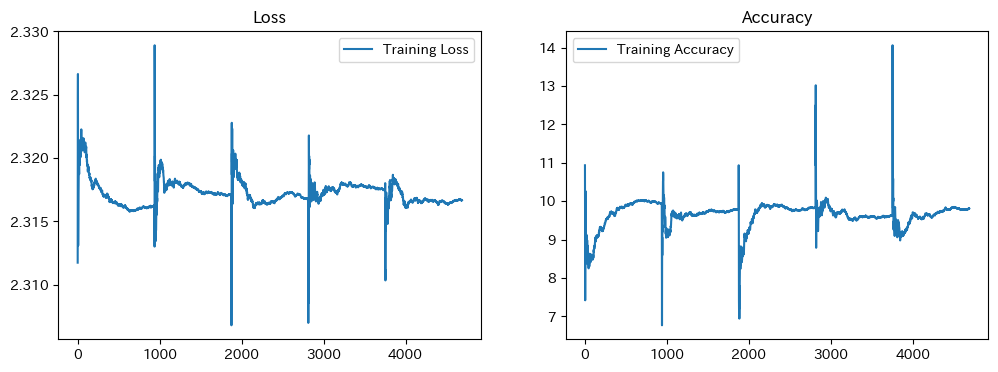

In [24]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# モデルの訓練
model = CNN().to(device)
model.train()
num_epochs = 5

# 損失と精度を記録するリスト
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data['image'], data['label']
        inputs = inputs.squeeze(2).float().to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # 損失と精度を記録
        train_losses.append(running_loss / (i+1))
        train_accuracies.append(100 * correct / total)

        print(f"エポック {epoch+1}\nイテレーション {i+1}\n損失: {running_loss / (i+1)}\n精度: {100 * correct / total}")
        print("---------------------------------------------")

print("完了")

# 損失と精度の推移をプロット
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

In [25]:
print(predicted)
print(labels)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([6, 6, 2, 2, 8, 6, 1, 3, 9, 8, 4, 1, 4, 7, 3, 3, 7, 8, 1, 7, 5, 3, 7, 5,
        9, 5, 9, 8, 1, 9, 0, 6], device='cuda:0')


#### 評価

In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# モデルを評価モードに設定
model.eval()
correct = 0

# データローダーを作成 (シャッフルなし)
test_loader = torch.utils.data.DataLoader(ds['train'], batch_size=64, shuffle=False)

# 予測とラベルを格納するリスト
predicts_list = []
labels_list = []
probs_list = []  # ROC曲線用の確率を格納

# 勾配計算を無効化
with torch.no_grad():
    for data in test_loader:
        # 画像とラベルを取得
        images, labels = data['image'], data['label']
        # 画像を適切な形状に変換し、デバイスに転送
        images = images.squeeze(2).float().to(device)
        labels = labels.to(device)

        # モデルに画像を入力して出力を取得
        outpts = model(images)
        # クラス1の確率を取得 (二値分類の場合)
        probs = outpts[:, 1]
        # 確率をリストに追加
        probs_list.extend(probs.cpu().numpy())

        # 予測結果を取得
        _, predicted = torch.max(outpts.data, 1)
        # 正答数を更新
        correct += (predicted == labels).sum().item()
        # 予測結果をNumPy配列に変換してリストに追加
        predicts_list.extend(predicted.cpu().numpy())
        # ラベルをNumPy配列に変換してリストに追加
        labels_list.extend(labels.cpu().numpy())

        # バッチごとの精度を出力 (監視用)
        print(f"バッチ精度: {100 * (predicted == labels).sum().item() / len(labels):.2f}%")
        print("-----------------------------------------------------------------")

出力の形状: torch.Size([64, 10])
予測: tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 8, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 7, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        3, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0], device='cuda:0')
実際: tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0], device='cuda:0')
バッチ精度: 95.31%
-----------------------------------------------------------------
出力の形状: torch.Size([64, 10])
予測: tensor([4, 5, 6, 1, 0, 0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 8, 0, 2, 6, 7, 8, 3, 9,
        0, 4, 6, 7, 4, 6, 8, 0, 7, 8, 3, 1, 5, 7, 1, 7, 1, 1, 6, 3, 0, 2, 9, 3,
        1, 1, 0, 4, 9, 2, 0, 0, 2, 0, 2, 7, 1, 8, 6, 4], device='cuda:0')
実際: tensor([4, 5, 6, 1, 0, 0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9,
        0, 4, 6, 7, 4, 6, 8, 0, 7, 8, 3, 1, 5, 7, 1, 7, 1, 1, 6, 3

In [19]:
print(f"predicts: {predicts_list[:10]}")
print(f"labels: {labels_list[:10]}")

predicts: [np.int64(5), np.int64(0), np.int64(4), np.int64(1), np.int64(9), np.int64(2), np.int64(1), np.int64(3), np.int64(1), np.int64(4)]
labels: [np.int64(5), np.int64(0), np.int64(4), np.int64(1), np.int64(9), np.int64(2), np.int64(1), np.int64(3), np.int64(1), np.int64(4)]


##### ヒートマップでビジュアライズ


全体の精度: 97.3000%
全体の適合率: 97.3992%
全体の再現率: 97.3000%
全体のF1スコア: 97.3032%

分類レポート:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5923
           1       0.99      0.99      0.99      6742
           2       0.94      0.99      0.97      5958
           3       0.99      0.96      0.97      6131
           4       1.00      0.95      0.97      5842
           5       0.99      0.97      0.98      5421
           6       0.99      0.98      0.99      5918
           7       0.94      0.99      0.97      6265
           8       0.92      0.98      0.95      5851
           9       0.99      0.91      0.95      5949

    accuracy                           0.97     60000
   macro avg       0.97      0.97      0.97     60000
weighted avg       0.97      0.97      0.97     60000



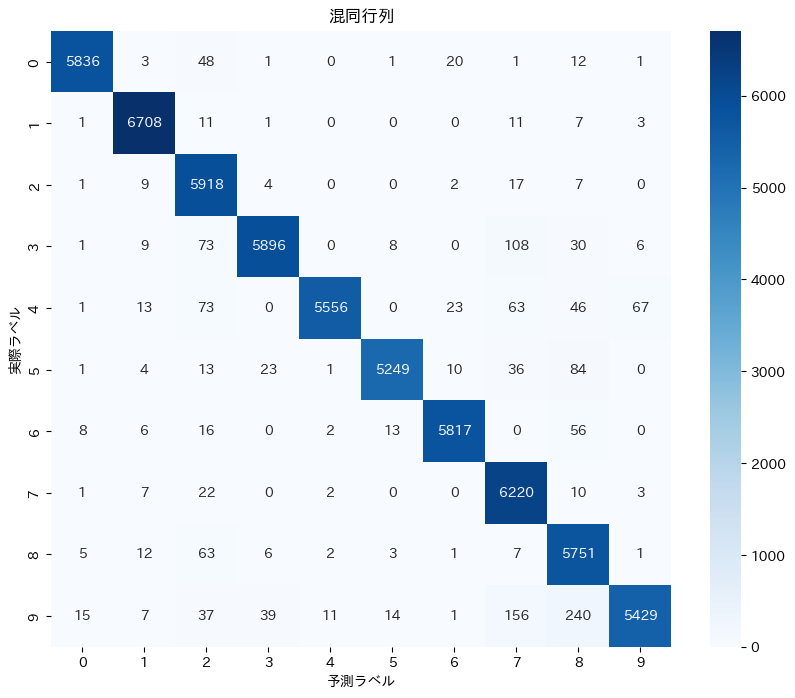

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 全体的な指標を計算して出力
accuracy = accuracy_score(labels_list, predicts_list)
precision = precision_score(labels_list, predicts_list, average='weighted')
recall = recall_score(labels_list, predicts_list, average='weighted')
f1 = f1_score(labels_list, predicts_list, average='weighted')

print(f"\n全体の精度: {accuracy * 100:.4f}%")
print(f"全体の適合率: {precision * 100:.4f}%")
print(f"全体の再現率: {recall * 100:.4f}%")
print(f"全体のF1スコア: {f1 * 100:.4f}%")

# 分類レポートを出力
print("\n分類レポート:")
print(classification_report(labels_list, predicts_list))

# 混同行列をプロット
cm = confusion_matrix(labels_list, predicts_list)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("混同行列")
plt.xlabel("予測ラベル")
plt.ylabel("実際ラベル")
plt.show()

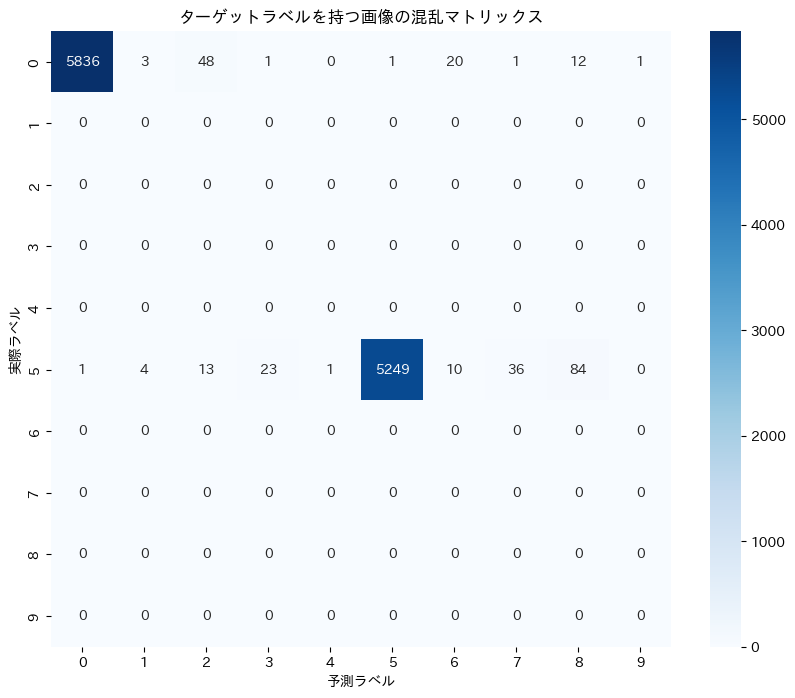

In [21]:
# 特定のラベルがついた画像のみをモデルに入力して、予測結果をヒートマップでプロット
model.eval()
target = [0, 5]
target_images = []
target_labels = []
target_predictions = []

with torch.no_grad():
    for i in range(len(ds['train'])):
        if ds['train'][i]['label'] in target:
            image = ds['train'][i]['image'].unsqueeze(0).float().to(device)
            label = ds['train'][i]['label']
            output = model(image)
            _, predicted = torch.max(output, 1)

            target_images.append(image)
            target_labels.append(label.item())
            target_predictions.append(predicted.cpu().item())

target_labels_tensor = torch.tensor(target_labels)
target_predictions_tensor = torch.tensor(target_predictions)

cm = confusion_matrix(target_labels_tensor, target_predictions_tensor)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("ターゲットラベルを持つ画像の混乱マトリックス")
plt.xlabel("予測ラベル")
plt.ylabel("実際ラベル")
plt.show()

In [22]:
# モデルの状態辞書を保存
torch.save(model.state_dict(), './streamlit-mnist-app/src/model/trained_mnist_cnn_model.pth')
print("モデルを保存しました")

モデルを保存しました


In [6]:
# モデルをロード
model.load_state_dict(torch.load('./streamlit-mnist-app/src/model/trained_mnist_cnn_model.pth'))

C:\Users\uenoj\AppData\Local\Temp\ipykernel_10164\4050255459.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./streamlit-mnist-app/src/

<All keys matched successfully>